In [1]:
import os
os.chdir('C:/Users/ASUS/Desktop/Data Science/Capstone Project')

In [57]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #for plotting
import seaborn as sea #for visualization
from collections import OrderedDict #to make sorted Dictionary

# Set a few plotting defaults
%matplotlib inline
plt.style.use('dark_background')
plt.rcParams['font.size'] = 15
plt.rcParams['patch.edgecolor'] = 'k'


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

In [4]:
sample=pd.read_csv('sample_submission.csv')
sample.head()

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,4


In [22]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [47]:
test['Target']=np.nan

# EDA and Data Cleaning

In [7]:
train.shape

(9557, 143)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [9]:
train.select_dtypes(['object']).head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


We will use ID idhogar later

Dependency: Number of Household younger than 19 or older than 64.,head of household, yes=1 and no=0
edjefe: years of education of male head of household,based on escolari, yes=1,no=0
edjefa: years of education of female head of household,based on interaction of escolari, yes=1, no=0
Hence , we can replace yes and no with 1 and 0 respectively

In [23]:
#Converting Object DataType to Integer
train['dependency']=train['dependency'].replace(('yes','no'),(1,0)).astype(np.float64)
train['edjefe']=train['edjefe'].replace(('yes','no'),(1,0)).astype(np.float64)
train['edjefa']=train['edjefa'].replace(('yes','no'),(1,0)).astype(np.float64)
test['dependency']=test['dependency'].replace(('yes','no'),(1,0)).astype(np.float64)
test['edjefe']=test['edjefe'].replace(('yes','no'),(1,0)).astype(np.float64)
test['edjefa']=test['edjefa'].replace(('yes','no'),(1,0)).astype(np.float64)

In [21]:
train[['dependency','edjefe','edjefa']].describe()


,dependency,edjefe,edjefa
count,9557.000000,9557.000000,9557.000000
mean,1.149550,5.096788,2.896830
std,1.605993,5.246513,4.612056
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,6.000000,0.000000
75%,1.333333,9.000000,6.000000
max,8.000000,21.000000,21.000000


Now let's look at integer data types.


2     101
13      5
97      3
22      3
11      3
10      3
9       3
7       3
6       2
4       2
14      1
1       1
dtype: int64


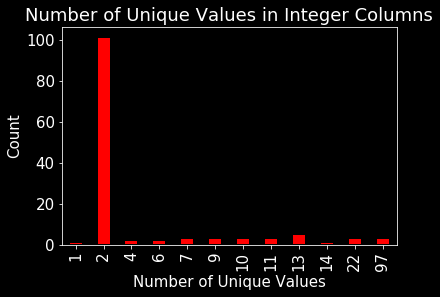

In [45]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color='red',edgecolor='k',linewidth=2)
plt.xlabel('Number of Unique Values')
plt.ylabel('Count')
plt.title('Number of Unique Values in Integer Columns')
print(train.select_dtypes(np.int64).nunique().value_counts())
plt.show()

Maximum number of interger columns has 2 unique values which is boolean values . This boolean expression is on household level. Since, we need final prediction on household level, we will not need these boolean columns to aggregate. However, boolean expressions on individual level is needed to be aggregated.

# Exploring Label Distribution

There are four possible integer levels describing about Poverty levels. 1: extreme poverty,2:moderate poverty,3:vulnerable poverty,4: non-vulnerable poverty. We need to optimally assign poverty level to household than individuals.i.e. ['parentsco1']==1 has to be considered as household head and indicate poverty data of ['idhogar'] rather that different poverty data for each individual in same houshold.

Let's see distribution of training labels

To make optimal analysis of this dataset, let's first combine train and test dataset

In [49]:
data=pd.concat([train,test],axis=0)

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64


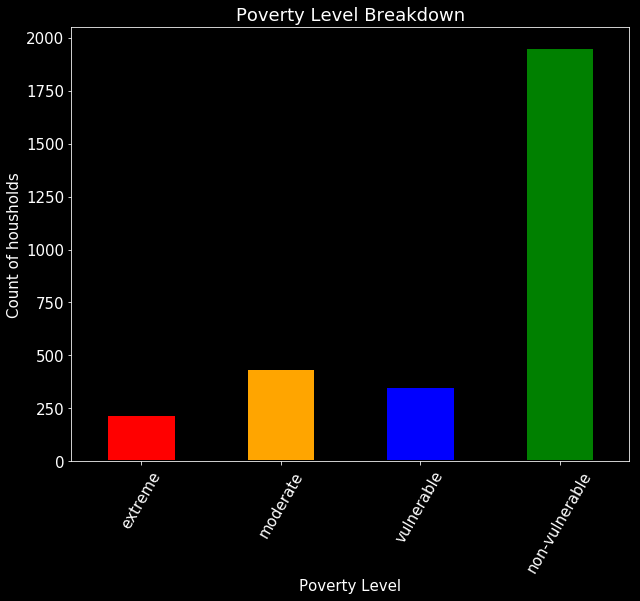

In [60]:
head=data.loc[data['parentesco1']==1].copy()

#Labels
labels=data.loc[(data['Target'].notnull()) & (data['parentesco1']==1),['Target','idhogar']]

#Value counts of Target
label_counts=labels['Target'].value_counts().sort_index()

# color mapping
colors=OrderedDict({1:'red',2:'orange',3:'blue',4:'green'})
poverty_mapping=OrderedDict({1:'extreme',2:'moderate',3:'vulnerable',4:'non-vulnerable'})

#visualization of labels distribution
label_counts.plot.bar(figsize=(10,8),color=colors.values(),edgecolor='k',linewidth=3)

#Formatting x-axis and y-axis
plt.xlabel('Poverty Level')
plt.ylabel('Count of housholds')
plt.xticks([x-1 for x in poverty_mapping.keys()],list(poverty_mapping.values()),rotation=60)
plt.title('Poverty Level Breakdown')
print(label_counts)
plt.show()

The problem with this label distribution is imbalance class. The number of households considered non-vulnerable is more than number of household in other poverty indicators. 
This imbalanced distribution may later led to classification problem while designing machine learning model. This may lead to inaccurate predictions. We have to address this issue.

# Wrong Labels

The other major issue which is needed to be addressed is to see that poverty targets are assigned on basis of households and not basis of individuals. If individuals within same [idhogar] is assigned different [Target] labels, we have to correct it, as according to requirement of this question, poverty of household is defined according to poverty label of household head i.e. [parentesco1].

Let's work on this and find equal and non-equal individual poverty labels of individuals in same households

In [22]:
#finding if null values is maximum for minors or people without education
print(train.loc[train['rez_esc'].isnull()]['age'].value_counts().head())
print(train.loc[train['rez_esc'].isnull()]['instlevel1'].value_counts())
print(train.loc[train['rez_esc'].isnull()]['instlevel2'].value_counts())

23    189
20    179
18    179
30    178
19    170
Name: age, dtype: int64
0    6745
1    1183
Name: instlevel1, dtype: int64
0    7031
1     897
Name: instlevel2, dtype: int64


In [23]:
# Estimating age of Children in School with descriptive statistics
print(train.loc[train['rez_esc'].notnull()]['age'].describe())

count    1629.000000
mean       12.258441
std         3.218325
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64


It is possible that rows with null values in rez_esc are of people who are out of school age and hecnce could not attend it. W replace null values with 0


In [24]:
train['rez_esc']=train['rez_esc'].fillna(0)

v2a1=Monthly Rent Payment which has null values
This could be because 1. They own a house(tipovivi1)
2. They own a house but paying in installments(tipovivi2)
3. They rented their house (tipovivi3)
4. Precarious reasons (tipovivi4)
5. They borrowed or assigned the house(tipovivi5)

In [25]:
print(train.loc[train['v2a1'].isnull()]['tipovivi1'].value_counts())
print(train.loc[train['v2a1'].isnull()]['tipovivi2'].value_counts())
print(train.loc[train['v2a1'].isnull()]['tipovivi3'].value_counts())
print(train.loc[train['v2a1'].isnull()]['tipovivi3'].value_counts())
print(train.loc[train['v2a1'].isnull()]['tipovivi4'].value_counts())
print(train.loc[train['v2a1'].isnull()]['tipovivi5'].value_counts())


1    5911
0     949
Name: tipovivi1, dtype: int64
0    6860
Name: tipovivi2, dtype: int64
0    6860
Name: tipovivi3, dtype: int64
0    6860
Name: tipovivi3, dtype: int64
0    6697
1     163
Name: tipovivi4, dtype: int64
0    6074
1     786
Name: tipovivi5, dtype: int64


In [26]:
# Thus, it is found that null values is because of Own Accomodation,precarious reasons and due to borrowed or assignement of house
train['v2a1']=train['v2a1'].fillna(0)

In [27]:
train['v2a1'].isnull().sum()

0

In [117]:
#Let's check on remaining missing values
missing_df=train.isnull().sum().to_frame().sort_values(0,ascending=False)
missing_df

,0
SQBmeaned,5
meaneduc,5
Id,0
hogar_mayor,0
parentesco10,0
parentesco11,0
parentesco12,0
idhogar,0
hogar_nin,0
hogar_adul,0


In [28]:
#Thus only two Columns are left with Missing Values. We replace missing values with mean of remaining data
train.fillna(train.mean(),inplace=True)


In [29]:
train.isnull().sum().value_counts()

0    143
dtype: int64

In [30]:
train.isna().sum().value_counts()

0    143
dtype: int64

Since, now no cloumn has null value left. Data Has been cleaned. Now, we need to look at Data Spread and remove outliers if any

# Removing Outliers

In [31]:
Column_names={'v2a1':'Monthly rent payment',
'hacdor' :'Overcrowding by bedrooms',
'rooms':'number of all rooms in the house',
'hacapo':'Overcrowding by rooms',
'v14a':'1 has bathroom in the household',
'refrig' :'1 if the household has refrigerator',
'v18q':'owns a tablet',
'v18q1': 'number of tablets household owns',
'r4h1': 'Males younger than 12 years of age',
'r4h2': 'Males 12 years of age and older',
'r4h3': 'Total males in the household',
'r4m1': 'Females younger than 12 years of age',
'r4m2': 'Females 12 years of age and older',
'r4m3': 'Total females in the household',
'r4t1': 'persons younger than 12 years of age',
'r4t2': 'persons 12 years of age and older',
'r4t3': 'Total persons in the household',
'tamhog': 'size of the household',
'tamviv': 'number of persons living in the household',
'escolari': 'years of schooling',
'rez_esc':'Years behind in school',
'hhsize': 'household size',
'paredblolad': '=1 if predominant material on the outside wall is block or brick',
'paredzocalo':"=1 if predominant material on the outside wall is socket (wood,  zinc or absbesto",
'paredpreb': '=1 if predominant material on the outside wall is prefabricated or cement',
'pareddes': '=1 if predominant material on the outside wall is waste material',
'paredmad': '=1 if predominant material on the outside wall is wood',
'paredzinc': '=1 if predominant material on the outside wall is zink',
'paredfibras': '=1 if predominant material on the outside wall is natural fibers',
'paredother': '=1 if predominant material on the outside wall is other',
'pisomoscer': "=1 if predominant material on the floor is mosaic,  ceramic,  terrazo",
'pisocemento': '=1 if predominant material on the floor is cement',
'pisoother': '=1 if predominant material on the floor is other',
'pisonatur': '=1 if predominant material on the floor is  natural material',
'pisonotiene': '=1 if no floor at the household',
'pisomadera': '=1 if predominant material on the floor is wood',
'techozinc': '=1 if predominant material on the roof is metal foil or zink',
'techoentrepiso': "=1 if predominant material on the roof is fiber cement,  mezzanine ",
'techocane': '=1 if predominant material on the roof is natural fibers',
'techootro': '=1 if predominant material on the roof is other',
'cielorazo': '=1 if the house has ceiling',
'abastaguadentro': '=1 if water provision inside the dwelling',
'abastaguafuera':'=1 if water provision outside the dwelling',
'abastaguano':'=1 if no water provision',
'public':"=1 electricity from CNFL,  ICE,  ESPH/JASEC",
'planpri':'1 electricity from private plant',
'noelec':'=1 no electricity in the dwelling',
'coopele':'=1 electricity from cooperative',
'sanitario1':'=1 no toilet in the dwelling',
'sanitario2':'=1 toilet connected to sewer or cesspool',
'sanitario3':'=1 toilet connected to  septic tank',
'sanitario5': '=1 toilet connected to black hole or letrine',
'sanitario6':'=1 toilet connected to other system',
'energcocinar1':'=1 no main source of energy used for cooking (no kitchen)',
'energcocinar2':'=1 main source of energy used for cooking electricity',
'energcocinar3':' main source of energy used for cooking gas',
'energcocinar4':'=1 main source of energy used for cooking wood charcoal',
'elimbasu1':'=1 if rubbish disposal mainly by tanker truck',
'elimbasu2':'=1 if rubbish disposal mainly by botan hollow or buried',
'elimbasu3':'=1 if rubbish disposal mainly by burning',
'elimbasu4':'=1 if rubbish disposal mainly by throwing in an unoccupied space',
'elimbasu5':"=1 if rubbish disposal mainly by throwing in river,  creek or sea",
'elimbasu6':'=1 if rubbish disposal mainly other',
'epared1':'=1 if walls are bad',
'epared2':'=1 if walls are regular',
'epared3':'=1 if walls are good',
'etecho1':'=1 if roof are bad',
'etecho2':'=1 if roof are regular',
'etecho3':'=1 if roof are good',
'eviv1':'=1 if floor are bad',
'eviv2':'=1 if floor are regular',
'eviv3':'=1 if floor are good',
'dis':'=1 if disable person',
'male':'=1 if male',
'female':'=1 if female',
'estadocivil1':'=1 if less than 10 years old',
'estadocivil2':'=1 if free or coupled uunion',
'estadocivil3':'=1 if married',
'estadocivil4':'=1 if divorced',
'estadocivil5':'=1 if separated',
'estadocivil6':'=1 if widow/er',
'estadocivil7':'=1 if single',
'parentesco1':'=1 if household head',
'parentesco2':'=1 if spouse/partner',
'parentesco3':'=1 if son/doughter',
'parentesco4':'=1 if stepson/doughter',
'parentesco5':'=1 if son/doughter in law',
'parentesco6':'=1 if grandson/doughter',
'parentesco7':'=1 if mother/father',
'parentesco8':'=1 if father/mother in law',
'parentesco9' :'=1 if brother/sister',
'parentesco10':'=1 if brother/sister in law',
'parentesco11':'=1 if other family member',
'parentesco12':'=1 if other non family member',
'idhogar':'Household level identifier',
'hogar_nin': 'Number of children 0 to 19 in household',
'hogar_adul': 'Number of adults in household',
'hogar_mayor':'# of individuals 65+ in the household',
'hogar_total':'# of total individuals in the household',
'dependency':'Dependency,Depencdency rate calculated',
'edjefe':'years of education of male head of household',
'edjefa':'years of education of female head of household',
'meaneduc':'average years of education for adults (18+)',
'instlevel1':'=1 no level of education',
'instlevel2':'=1 incomplete primary',
'instlevel3':'=1 complete primary',
'instlevel4':'=1 incomplete academic secondary level',
'instlevel5':'=1 complete academic secondary level',
'instlevel6':'=1 incomplete technical secondary level',
'instlevel7':'=1 complete technical secondary level',
'instlevel8':'=1 undergraduate and higher education',
'instlevel9':'=1 postgraduate higher education',
'bedrooms':'number of bedrooms',
'overcrowding':'# persons per room',
'tipovivi1':'=1 own and fully paid house',
'tipovivi2':"=1 own,  paying in installments",
'tipovivi3':'=1 rented',
'tipovivi4' :'1 precarious',
'tipovivi5':"=1 other(assigned,  borrowed)",
'computer':'=1 if the household has notebook or desktop computer',
'television':'=1 if the household has TV',
'mobilephone':'1 if mobile phone',
'qmobilephone':'# of mobile phones',
'lugar1':'=1 region Central',
'lugar2':'=1 region Chorotega',
'lugar3':'=1 region PacÃƒÂ¬fico central',
'lugar4':'=1 region Brunca',
'lugar5':'=1 region Huetar AtlÃƒÂ¡ntica',
'lugar6':'=1 region Huetar Norte',
'area1':'=1 zona urbana',
'area2':'=2 zona rural',
'age':'Age in years',
'SQBescolari':'escolari squared',
'SQBage':'age squared',
'SQBhogar_total':'hogar_total squared',
'SQBedjefe':'edjefe squared',
'SQBhogar_nin':'hogar_nin squared',
'SQBovercrowding':'overcrowding squared',
'SQBdependency':'dependency squared',
'SQBmeaned':' square of the mean years of education of adults (>=18) in the household',
'agesq':'Age squared'
}

# Calculating Correlation between Variables

In [32]:
train_corr=train.corr()['Target'].abs().sort_values()
train_corr
print('Correlations between Target and Household Variables')

planpri            0.000545
paredother         0.000629
coopele            0.002270
estadocivil6       0.003372
estadocivil7       0.004585
hogar_mayor        0.005159
instlevel6         0.006014
parentesco7        0.006216
tipovivi1          0.007435
tipovivi3          0.008393
parentesco8        0.008562
public             0.009074
parentesco10       0.010990
parentesco9        0.012318
sanitario6         0.012954
parentesco12       0.014421
instlevel4         0.014759
parentesco5        0.016534
lugar2             0.018523
parentesco11       0.019076
techoentrepiso     0.019592
parentesco4        0.020887
pisoother          0.021219
instlevel3         0.021986
elimbasu6          0.024506
techozinc          0.027652
paredfibras        0.027730
estadocivil2       0.029669
techootro          0.032433
noelec             0.033974
                     ...   
hacdor             0.191714
qmobilephone       0.199707
v18q1              0.201754
epared1            0.203025
pisocemento        0

We can see that Correlation between income level groups and household indicators are less. Hence, no direct relation can be established. We now have to build up identification model on basis of best correlated variables

In [38]:
best_corr=train_corr.tail(30)

In [52]:
best_corr=best_corr.index
best_corr

Index(['hacdor', 'qmobilephone', 'v18q1', 'epared1', 'pisocemento', 'eviv1',
       'instlevel8', 'rooms', 'r4h1', 'v18q', 'edjefe', 'SQBedjefe', 'r4m1',
       'etecho3', 'SQBovercrowding', 'paredblolad', 'SQBmeaned', 'pisomoscer',
       'overcrowding', 'epared3', 'eviv3', 'SQBescolari', 'escolari',
       'cielorazo', 'SQBhogar_nin', 'r4t1', 'hogar_nin', 'meaneduc', 'Target',
       'elimbasu5'],
      dtype='object')

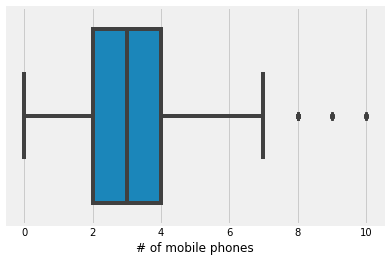

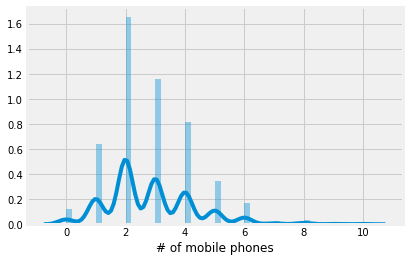

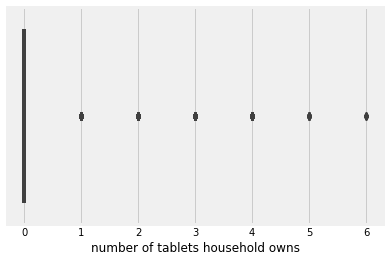

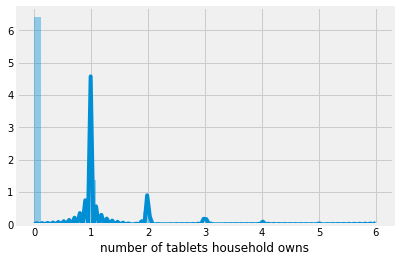

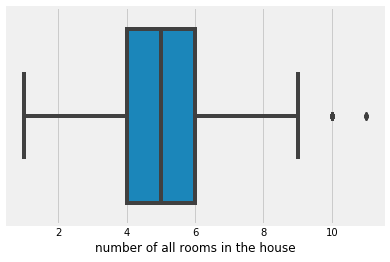

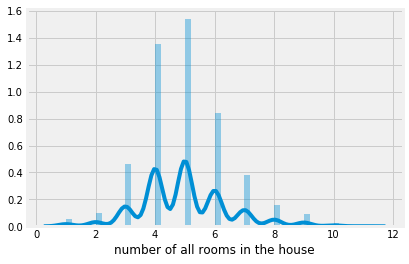

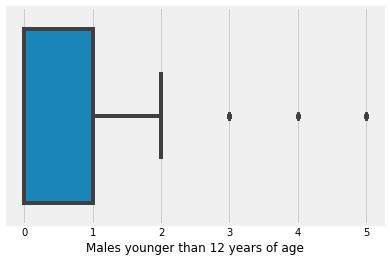

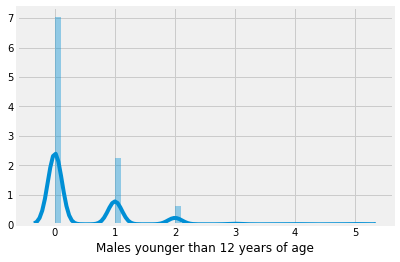

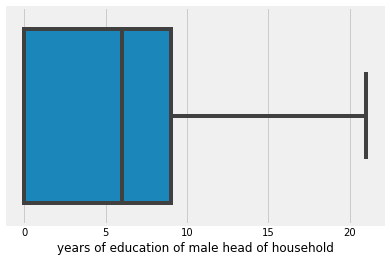

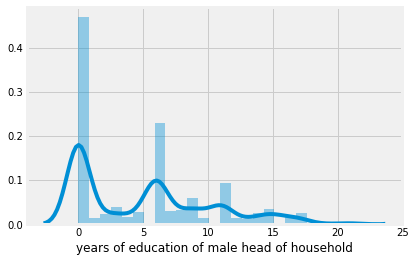

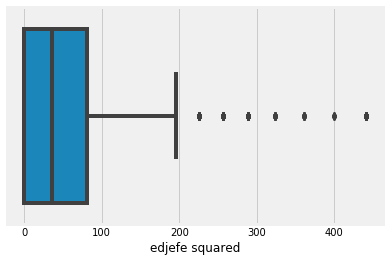

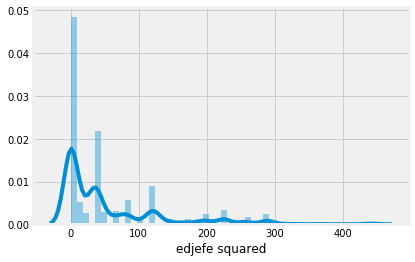

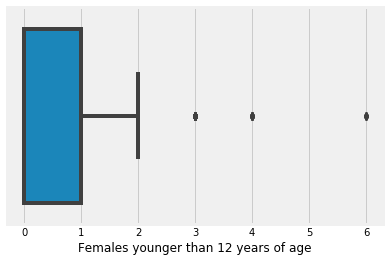

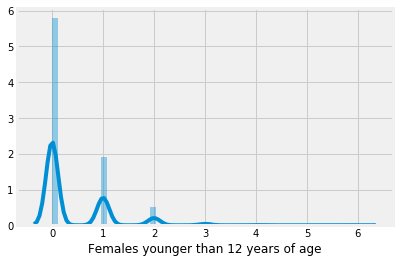

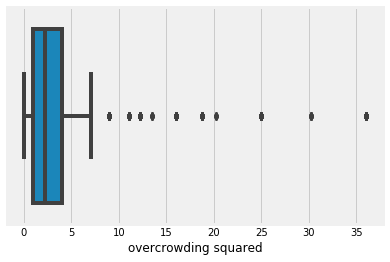

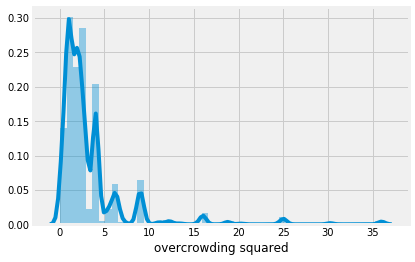

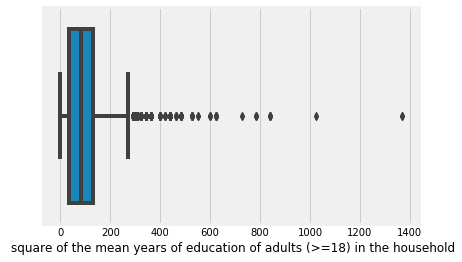

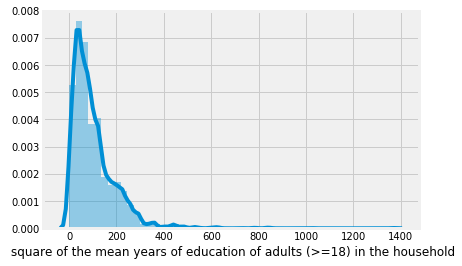

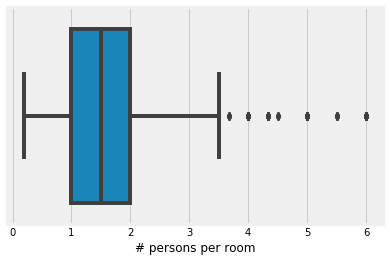

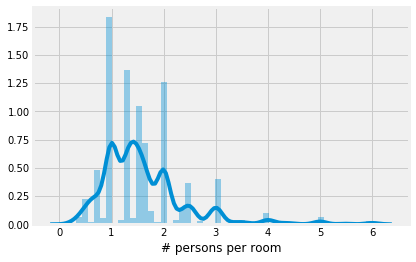

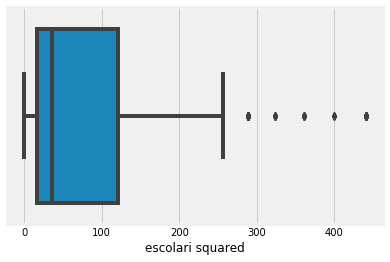

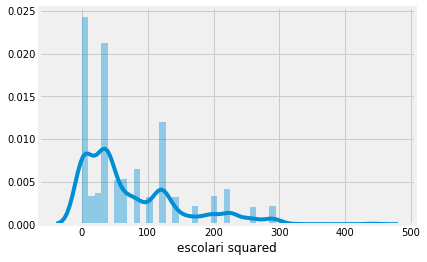

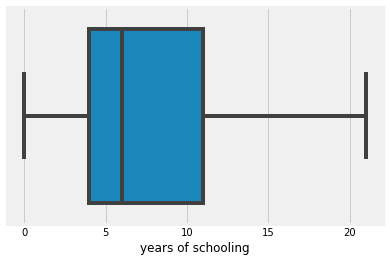

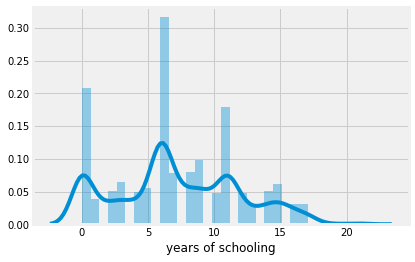

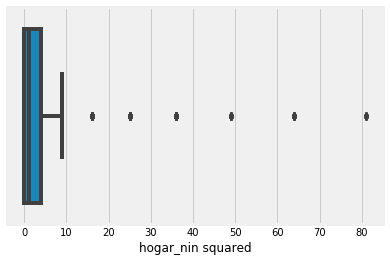

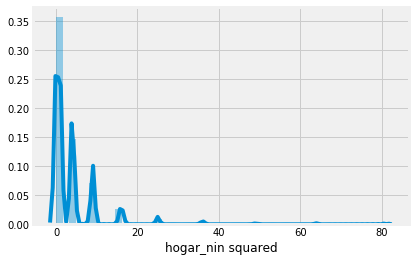

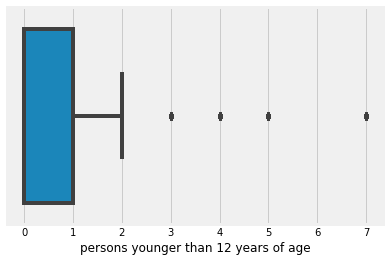

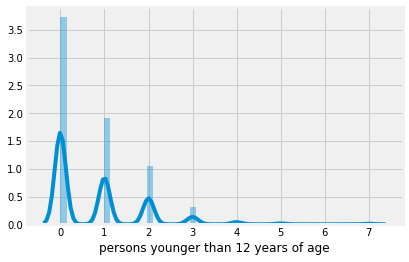

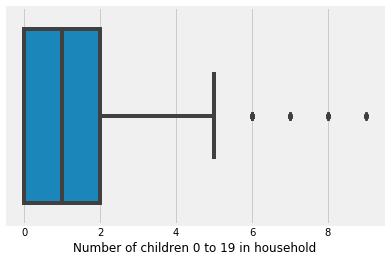

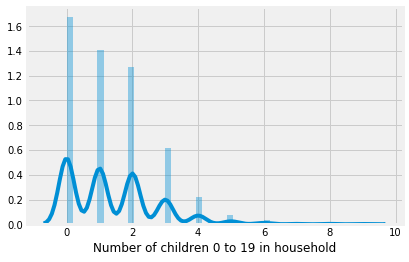

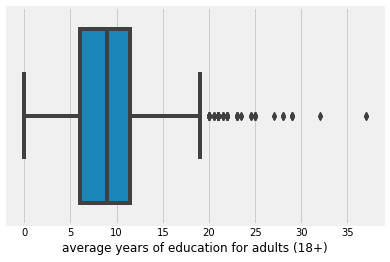

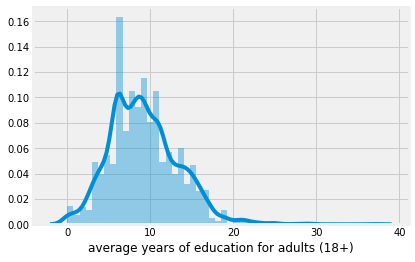

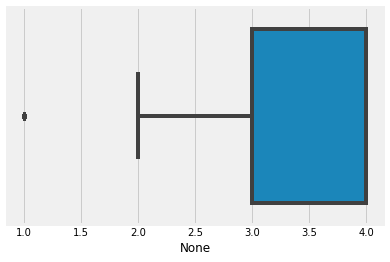

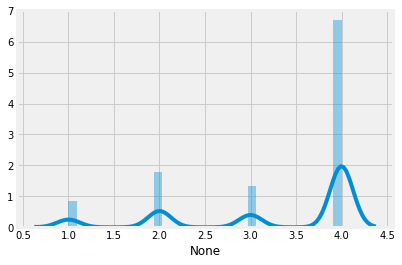

In [54]:
for i in best_corr:
    if len(train[i].unique())>2:
        sea.boxplot(train[i])
        plt.xlabel(Column_names.get(i))
        plt.show()
        sea.distplot(train[i])
        plt.xlabel(Column_names.get(i))
        plt.show()
        
    

In [70]:
to_drop=train.loc[(train['r4h1']>2)|(train['SQBedjefe']>900)|(train['r4m1']>3)|(train['SQBovercrowding']>25)|
                  (train['SQBmeaned']>900)|(train['overcrowding']>5)|(train['SQBescolari']>300)|(train['SQBhogar_nin']>70)|
                  (train['r4t1']>5)|(train['hogar_nin']>6)|(train['meaneduc']>25)].index

In [71]:
len(to_drop)

236

In [72]:
train.groupby('Target').mean()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
Target,,,,,,,,,,,,,,,,,,,,,
1,17185.945695,0.147020,4.327152,0.075497,0.988079,0.887417,0.079470,0.137748,0.796026,1.160265,...,28.435762,37.505960,1293.280795,24.860927,17.030464,9.156291,5.264670,5.664459,61.361065,1293.280795
2,20472.204759,0.067627,4.483406,0.047589,0.986850,0.928616,0.078272,0.099562,0.560426,1.474640,...,31.160927,41.201628,1506.677520,22.254227,26.670006,6.390106,4.814560,5.344108,66.493663,1506.677520
3,25463.546733,0.048801,4.729529,0.030604,0.991729,0.961952,0.118280,0.151365,0.405294,1.692308,...,33.314309,48.546733,1616.382961,21.687345,38.487179,4.418528,3.865657,4.937991,68.842169,1616.382961
4,61570.166111,0.014343,5.205971,0.009340,0.998332,0.973316,0.314710,0.444296,0.283856,1.605070,...,36.078886,92.818212,1729.945464,17.065210,68.265677,2.382422,2.454649,3.084552,124.198405,1729.945464


# Data Visualisation

In [81]:
train['Target']=train['Target'].astype('int32')
train['Target'].replace((1,2,3,4),('extreme poverty','moderate poverty','vulnerable households','non vulnerble households'),inplace=True)


In [ ]:
plt.hist('Target',data=train)
plt.show()
plt.title('Household Poverty levels')